In [1]:
import torch
import random
import pandas as pd
import numpy as np
from IPython.display import clear_output
import torch
from torchvision import transforms
import warnings


# to ignore torchvision model warnings
warnings.filterwarnings(
    action='ignore',
    category=DeprecationWarning,
    
    module=r'.*randpool'
)

# **Overview**
<font size="3">
This Notebook aims to demonstrate one of the inherent weaknesses of using convolutional neural networks (CNN's) in safety critical systems such as security systems, autonomous driving applications and more. The notebook offers a walk through of the steps and code necessary for you to understand the concepts involved and to try out the idea for yourself. Please feel free to re-use any code you see in this document.</font>

* <pre> demo.ipynb   ->  demonstration notebook to follow along</pre> 
* <pre> image.py     ->  supporting python file that provides the Image class and additional functionality I created</pre> 





## The weakness
**The Architecture:**
 CNN's and NN's rely on precise weights that have been calibrated through the propagation of training errors to correct these prediction weights that are stored in the neurons of the hidden layers in the networks.
<br />
<br />
**The Hypotheses:**
If we had access the the model (and therefore the neuron weights) used in these safety critical systems we could potential exploit their over reliance on particular neurons and their associated weights to adjust the model predictions to our benefit.
<br />
<br />
**The Approach:**
This notebook uses the famous ResNet-18 model as an example of how these weights can be used to our advantage as well as some new arbitrary and unseen images for the model to make predictions on.




In [2]:
from PIL import Image

<font size="3">We will be using the Python Imaging Library (PIL) to make precise changes to our images</font>

In [3]:
our_banana_raw = Image.open('/Users/ted.taylor/Downloads/ban.jpg')
print(f"Original size : {our_banana_raw.size}") # 5464x3640

our_banana = our_banana_raw.resize((256, 256))

Original size : (1200, 1057)


<font size="3">Now we need to import an example image for the model to make predictions on, in this case our example image is just a banana, we should also resize our image to 256 x 256 which are the dimensions ResNet-18 requires</font>

In [4]:
from image import Image, pred

Using cache found in /Users/ted.taylor/.cache/torch/hub/pytorch_vision_v0.10.0
/Users/ted.taylor/opt/anaconda3/envs/envAltair/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/Users/ted.taylor/opt/anaconda3/envs/envAltair/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


<font size="3">We should also import our supporting python file  (and the pred method) which contains many of the supporting methods I created </font>

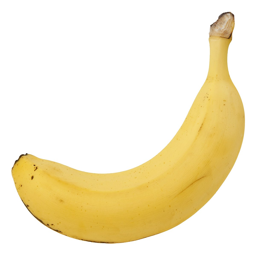

In [5]:
our_image = Image(our_banana)
our_image.matrix

<font size="3">We can then create an Image object by passing in our image we loaded, we can then view this image using the .matrix function on our Image object</font>


In [6]:
print(f"{len(pred(our_image.matrix))}\n")
pred(our_image.matrix, 5)

1000



[('banana', 99.97368621826172),
 ('hook', 0.00846079457551241),
 ('lemon', 0.005604405887424946),
 ('slug', 0.0033339131623506546),
 ('spaghetti squash', 0.0027643986977636814)]

By passing our image to the pred() function we can see it returns a list containing 1000 elements, we can also pass in an integer to limit the results to the top 'n' predictions, in this case we only really want to look at the top 5
<br /><br />
**As we can see the ResNet-18 model stored within the image file is ~99.9% sure our image is a banana!**
<br /><br />
Lets start our attack by changing one random pixel to a random RGB color in the image and see how this impacts the predictions... 

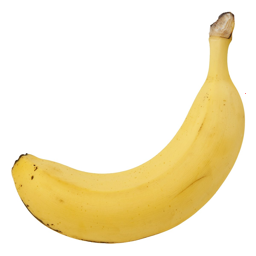

In [7]:
new_image = our_image.matrix.copy() # use.copy() to avoid changing our image

x_rand = random.randint(0, 255)
y_rand = random.randint(0, 255)

r_rand = random.randint(0, 255)
g_rand = random.randint(0, 255)
b_rand = random.randint(0, 255)

old_pixel_val = new_image.load()[x_rand,y_rand]
new_pixel_val = (r_rand,g_rand,b_rand)

new_image.load()[x_rand,y_rand] = (r_rand,g_rand,b_rand)

# display new image 
new_image

In [8]:
pred(new_image,5)

[('banana', 99.97368621826172),
 ('hook', 0.00846079457551241),
 ('lemon', 0.005604405887424946),
 ('slug', 0.0033339131623506546),
 ('spaghetti squash', 0.0027643986977636814)]

# **Where the magic happens**

<font size="3">As you can see there is a new orange colored pixel just to the right hand side of the banana and when we re-ran a prediction for this new image the confidence that the model thinks it is a banana has decreased by ~0.0002 %</font>
<br /><br />
<font size="3">**We can now take a brute force attack approach and simply write a function which places pixels of random colors in random locations and see how it impacts the weights. If the pixel decreases the confidence keep the change, else discard the change**</font>
<br /><br />
<font size="3">Further more we can track the values of all the other predictions and write a stopping function to only stop placing pixels once a different item e.g. a 'spaghetti squash' is the most confident prediction. </font>
<br /><br />
<font size="3">We can do this using the trick() method which takes 2 additional parameters..</font>
* <pre> name: str                             ->  name of the item we want to target</pre> 
* <pre> hault_threshold: int (detault=95)     ->  at what confidence threshold do we want to stop at</pre> 
</br>




In [21]:
result = our_image.trick(name='spaghetti squash')

change no. 477
old n_sub1_value: 94.94392395019531
new n_sub1_value: 95.02627563476562
Finished - After 478 changes


In [22]:
# the original banana predictions
result[0][:5]

[('banana', 99.97368621826172),
 ('hook', 0.00846079457551241),
 ('lemon', 0.005604405887424946),
 ('slug', 0.0033339131623506546),
 ('spaghetti squash', 0.0027643986977636814)]

In [23]:
# the new banana predictions
result[1][:5]

[('spaghetti squash', 95.02627563476562),
 ('banana', 1.6303976774215698),
 ('lemon', 1.5404499769210815),
 ('acorn squash', 0.4977218806743622),
 ('butternut squash', 0.2352895438671112)]

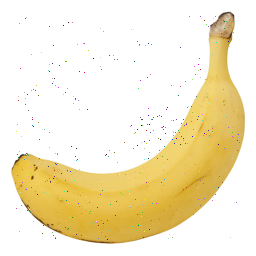

In [24]:
# the new banana image
result[2]

<font size="3">This function returns a list of objects that contains 1) the original predictions 2) the new predictions 3) the new image. In this case the trick function required 477 changes for the model to be 95% confident our picture was a spaghetti squash</font>
<br /><br />
<font size="3">**Although to us this image is obviously still a banana the ResNet-18 model believes it is now spaghetti squash.**</font>
<br /><br />
<font size="3">Here is an example of the same thing but this time starting from an entirely white image.</font>

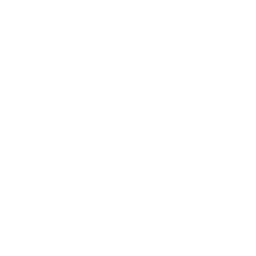

In [5]:
white_image = our_banana_raw.resize((256, 256))
for i in range(0,255):
    for j in range(0,255):
        white_image.load()[i,j] = (255,255,255)
        
our_white_image = Image(white_image)

# display the white image
our_white_image.matrix

In [37]:
result = our_white_image.trick('eggnog')

change no. 239
old n_sub1_value: 94.92180633544922
new n_sub1_value: 95.05668640136719
Finished - After 240 changes


In [41]:
# the original white image predictions
result[0][:5]

[('corkscrew', 1.8588545322418213),
 ('hook', 1.1945443153381348),
 ('hair slide', 1.153014063835144),
 ('nail', 1.1527196168899536),
 ('whistle', 1.0341063737869263)]

In [42]:
# the new white image predictions
result[1][:5]

[('eggnog', 95.05668640136719),
 ('bubble', 0.5116955637931824),
 ('beer glass', 0.3971010446548462),
 ('Petri dish', 0.3310294449329376),
 ('dough', 0.3239884078502655)]

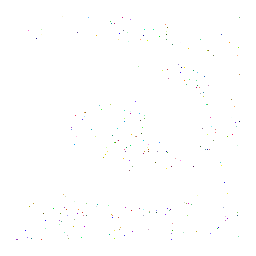

In [40]:
# the new white image
result[2]

# **Further Thoughts and Recommendations**

<font size="3">**Image Noise -**
Many of these pixels are likely picking up on some of the noise in the training images as ResNet-18 is trained on images that don't go through much pre-processing to remove such noise. We can assume this because the pixels are small enough to be associated to very small artifacts that may have been in the training images and therefore greatly increase the weights for such classes.</font>
<br /><br />
<font size="3">**Real World Impact -**
Although this may seem scary and appear as a fatal flaw in computer vision the real world impact of these type of scenarios are likely to be minimal. 
<br /><br />
The reason for this is that such artifacts are extremely unlikely to occur in nature and is therefore a trade off we can be willing to make in pursuit of the benefits the computer vision systems provide.
<br /><br />
The only realistic threat that could exploit this is a bad actor who has access to the model and wants to alter the computer vision system to their gain. For example avoid object recognition systems as demonstrated in this article https://www.theverge.com/2019/4/23/18512472/fool-ai-surveillance-adversarial-example-yolov2-person-detection.
<br /><br />
However, this too can easily be avoided by companies by ensuring they use models that are trained in-house and are not open source based models. Furthermore having tight security around the training and of course storage of the model is a must.
</font>
<br /><br />
<font size="3">**The importance of pre-processing -**
This demonstrates the importance of pre-processing images in computer vision in general. However, this presents a large trade-off as the pre-processing process itself may lead to further weaknesses and is itself a mammoth task to undertake and is very difficult to get right for safety critical systems.</font>

# **Use In Image Generation**

<font size="3">As discussed above this approach demonstrated relies on picking up on unique artifacts in the image which is likely to be noise in the training data. What about if instead we places larger images or shapes for example? What would happen then?
</font>

<font size="3"> Now we are using the genImage() function from our image file which places a random size and color circle in a random location on our blank canvas until it increases the confidence that ResNet-18 think that it's an 'acorn'. This once again uses a brute force approach and therefore requires similar parameters to last time...
</font>
<br /><br />
* <pre> name: str                             ->  name of the item we want to target</pre> 
* <pre> hault_threshold: int (default=95)     ->  at what confidence threshold do we want to stop at</pre> 
* <pre> learning_rate: float (default=0.1)    ->  only accept changes that increase confidence by greater than this value
</pre> 
<br />

In [11]:
white_canvas = Image(white_image.copy())
result = white_canvas.genImage(name='lemon', hault_threshold=95, learning_rate=5)

Attempt No.1492 
Placement No.14 
prev: 92.85154724121094 
current: 95.7078857421875
Finished - After 15 changes


In [19]:
# the original white canvas predictions
result[0][:5]

[('corkscrew', 1.8588545322418213),
 ('hook', 1.1945443153381348),
 ('hair slide', 1.153014063835144),
 ('nail', 1.1527196168899536),
 ('whistle', 1.0341063737869263)]

In [13]:
# the computer-drawn image predictions
result[1][:5]

[('lemon', 95.7078857421875),
 ('orange', 1.6821608543395996),
 ('balloon', 0.7420437932014465),
 ('tennis ball', 0.49139735102653503),
 ('lampshade', 0.23371966183185577)]

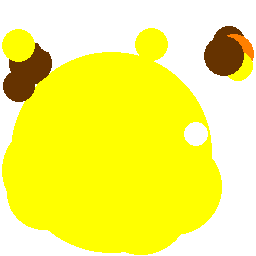

In [21]:
# what the computer drew (using random circles only) until it was >95% sure it was drawing a 'lemon'
result[2]

### Improvements to this image generation


<font size="3"> Although this is a very crude image generation method and far more advanced generative adversarial neural networks (GANN's) exist thinking and testing of improvements for such systems can help us better understand NN's in general and how their hidden layers work.
</font>

* Count what colors and sizes are used most in plots - once the prediction reaches 25% the target then restart with most common color & sizes having increased weights/ probability they will be placed
* use k counter to nudge out of a local minimum - draw a white border around edge of image if it gets stuck to nudge it on wards
* total pixel value count - if less than 1/4 of pixels are not equal to 255,255,255 (white) at 25% target then restart process (avoids creating small objects and capturing noise)
* use random shape & size brush strokes instead of circles